In [172]:
import pandas as pd
import numpy as np
import pybaseball as pyb
import matplotlib.pyplot as plt
import seaborn as sns
pyb.cache.enable()

In [173]:
statcast_data = pyb.statcast(start_dt='2023-03-30', end_dt='2023-8-30')

This is a large query, it may take a moment to complete


100%|██████████| 154/154 [00:03<00:00, 41.32it/s]


### Goal: To see and understand how a starting MLB pitcher’s performance evolves over a 5 year period.

## Function that quiry Pitcher's information given name

In [174]:
features_to_keep_main = [
    'pitch_type', 
    'game_date', 
    'release_speed', 
    'release_pos_x', 
    'release_pos_z', 
    'player_name', 
    'pitch_name',
    'events', 
    'zone', 
    'balls', 
    'strikes', 
    'game_year', 
    'pfx_x', 
    'pfx_z', 
    'plate_x', 
    'plate_z', 
    'outs_when_up', 
    'inning', 
    'inning_topbot', 
    'release_spin_rate', 
    'release_extension', 
    'delta_home_win_exp', 
    'delta_run_exp'
]

start_time_main = '2015-04-01'
end_time_main = '2020-07-15'


In [181]:
def get_pitchers_info(firstname, lastname, features_to_keep=features_to_keep_main, start_time=start_time_main, end_time=end_time_main):
    player_info = pyb.playerid_lookup(lastname, firstname)
    
    if player_info.empty:
        raise ValueError(f"No player found for name: {firstname} {lastname}")
    
    player_id = player_info['key_mlbam'].iloc[0]
    print(f'Pitcher ID:{player_id}')
    data = pyb.statcast_pitcher(start_time, end_time, player_id=player_id)
    # print(data.columns)
    filtered_data = data[features_to_keep]
    filtered_data = filtered_data.dropna()

    earlist = pd.to_datetime(sorted(filtered_data.game_date.unique())[0])
    latest = pd.to_datetime(sorted(filtered_data.game_date.unique())[-1])
    print(f'Loaded data for pitcher {firstname} {lastname} from {earlist} to {latest}')
    print(f'with {filtered_data.shape[0]} data points and {filtered_data.shape[1]} features')
    print()
    return filtered_data

In [182]:
firstname = 'patrick'
lastname = 'corbin'
player_name = 'Patrick Corbin'
pat_df = get_pitchers_info(firstname, lastname)

Pitcher ID:571578
Gathering Player Data
Loaded data for pitcher patrick corbin from 2015-07-04 00:00:00 to 2019-10-30 00:00:00
with 3455 data points and 23 features



/Users/baohu/anaconda3/lib/python3.11/site-packages/pybaseball/utils.py:295: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(data.text))


In [183]:
def plot(df, columnName, playerName):
    df['game_date'] = pd.to_datetime(df['game_date'])


    df['date_num'] = df['game_date'].map(pd.Timestamp.toordinal)


    plt.figure(figsize=(10, 6))


    sns.regplot(x='date_num', y=columnName, data=df, scatter_kws={'s': 10}, line_kws={'color': 'red'}, lowess=True)


    ax = plt.gca()
    ax.set_xticks(df['date_num'][::len(df)//6])  
    ax.set_xticklabels(df['game_date'].dt.strftime("%Y-%m-%d")[::len(df)//6], rotation=45)

    plt.xlabel('Date')
    plt.ylabel(columnName)
    plt.title(f'Average {columnName} of {playerName}')

    plt.show()

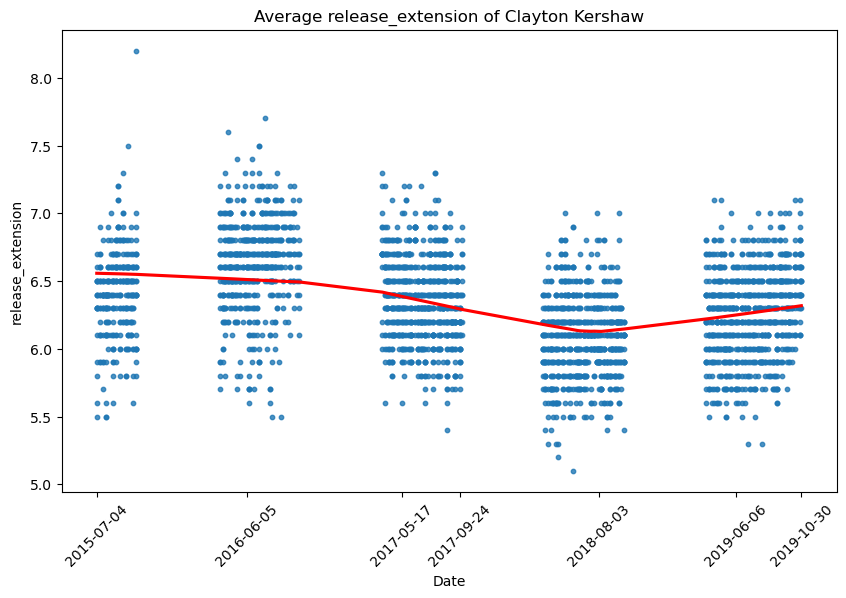

In [195]:
plot(pat_df, 'release_extension', player_name)

In [185]:
pat_df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,pitch_name,events,zone,balls,...,plate_x,plate_z,outs_when_up,inning,inning_topbot,release_spin_rate,release_extension,delta_home_win_exp,delta_run_exp,date_num
72,SL,2019-10-30,82.8,2.27,6.30,"Corbin, Patrick",Slider,strikeout,7.0,3,...,-0.63,2.10,2,8,Bot,2357.0,6.6,-0.016,-0.138,737362
80,SL,2019-10-30,81.3,2.37,6.47,"Corbin, Patrick",Slider,field_out,9.0,1,...,0.65,2.14,1,8,Bot,2348.0,6.4,-0.028,-0.206,737362
82,FF,2019-10-30,95.5,2.03,6.33,"Corbin, Patrick",4-Seam Fastball,strikeout,13.0,2,...,-1.20,2.53,0,8,Bot,2432.0,6.6,-0.041,-0.217,737362
88,SL,2019-10-30,82.6,2.42,6.30,"Corbin, Patrick",Slider,field_out,13.0,0,...,-1.13,1.83,2,7,Bot,2304.0,6.5,-0.052,-0.141,737362
91,FF,2019-10-30,93.2,2.20,6.29,"Corbin, Patrick",4-Seam Fastball,single,5.0,2,...,-0.12,2.43,2,7,Bot,2201.0,6.7,0.029,0.144,737362


In [186]:
def scatter_whole_data(df):
    df['game_date'] = pd.to_datetime(df['game_date'])

    plt.figure(figsize=(12, 8))

    sns.scatterplot(x='pfx_x', y='pfx_z', hue='pitch_name', data=df, palette='deep')

    plt.xlabel('Horizontal Movement (pfx_x)')
    plt.ylabel('Vertical Movement (pfx_z)')
    plt.title(f'{pat_df.player_name.iloc[0]}\'s Pitch Movement by Pitch Type')
    plt.legend(title='Pitch Type')

    plt.show()



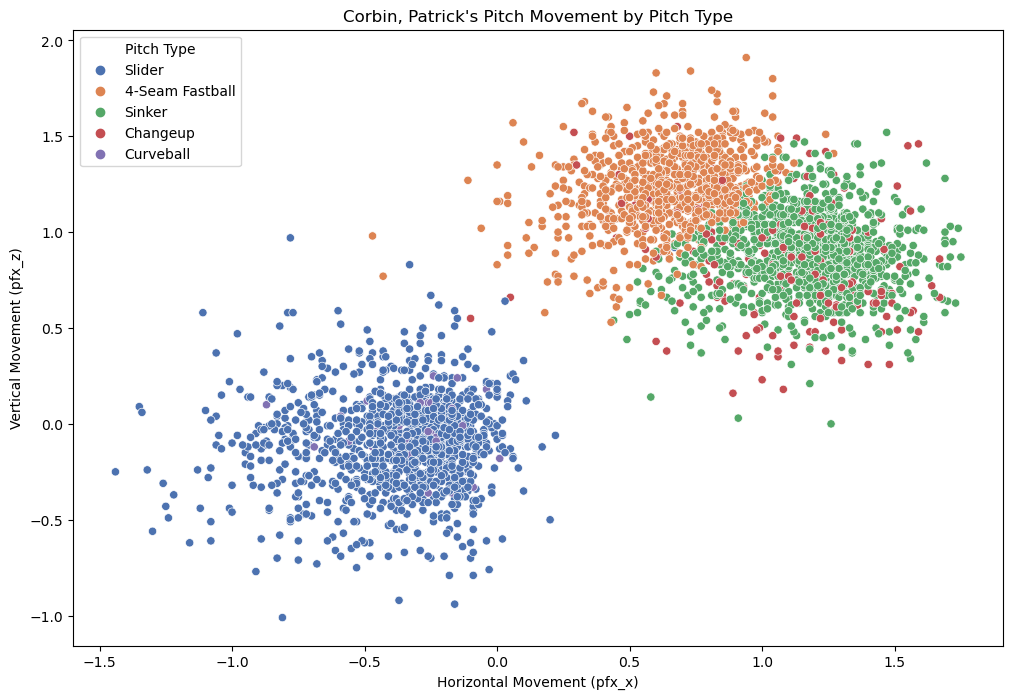

In [187]:
scatter_whole_data(pat_df)

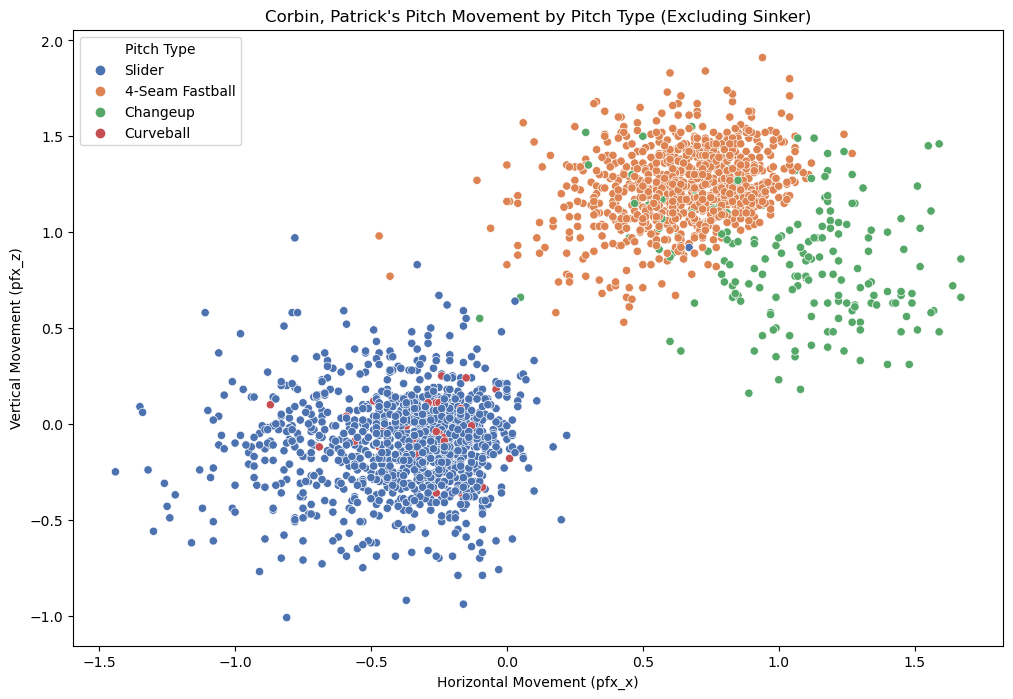

In [188]:
filtered_pat_df = pat_df.query('pitch_name != "Sinker"')


filtered_pat_df['game_date'] = pd.to_datetime(filtered_pat_df['game_date'])


plt.figure(figsize=(12, 8))


sns.scatterplot(x='pfx_x', y='pfx_z', hue='pitch_name', data=filtered_pat_df, palette='deep')


plt.xlabel('Horizontal Movement (pfx_x)')
plt.ylabel('Vertical Movement (pfx_z)')
plt.title("Corbin, Patrick's Pitch Movement by Pitch Type (Excluding Sinker)")
plt.legend(title='Pitch Type')


plt.show()

In [189]:
# def scatter_of_5_years(df):
#     df['game_date'] = pd.to_datetime(df['game_date'])


#     years = sorted(pat_df['game_year'].unique())


#     rows = len(years) // 2 + len(years) % 2
#     cols = 2

#     fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 6))
#     axes = axes.flatten()


#     palette = sns.color_palette("deep", n_colors=len(df['pitch_name'].unique()))
#     hue_order = df['pitch_name'].unique()

#     player_name = df.player_name.iloc[0]
#     for i, year in enumerate(years):
#         yearly_data = df[df['game_year'] == year]
        
#         sns.scatterplot(ax=axes[i], x='pfx_x', y='pfx_z', hue='pitch_name', data=yearly_data,
#                         palette=palette, hue_order=hue_order)
        

#         axes[i].set_xlabel('Horizontal Movement (pfx_x)')
#         axes[i].set_ylabel('Vertical Movement (pfx_z)')
#         axes[i].set_title(f"{player_name}\'s Pitch Movement by Pitch Type in {year}")
#         axes[i].legend(title='Pitch Type')


#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

In [190]:
# scatter_of_5_years(pat_df)

In [196]:
def scatter_of_5_Years(df):
    df['game_date'] = pd.to_datetime(df['game_date'])

    years = sorted(df['game_year'].unique())

    rows = len(years) // 2 + len(years) % 2
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 6))
    axes = axes.flatten()

    palette = sns.color_palette("deep", n_colors=len(df['pitch_name'].unique()))
    hue_order = sorted(df['pitch_name'].unique())

    player_name = df['player_name'].iloc[0]
    for i, year in enumerate(years):
        yearly_data = df[df['game_year'] == year]
        
        sns.scatterplot(ax=axes[i], x='pfx_x', y='pfx_z', hue='pitch_name', data=yearly_data,
                        palette=palette, hue_order=hue_order)
        
        axes[i].set_xlabel('Horizontal Movement (pfx_x)')
        axes[i].set_ylabel('Vertical Movement (pfx_z)')
        axes[i].set_title(f"{player_name}\'s Pitch Movement by Pitch Type in {year}")
        axes[i].legend(title='Pitch Type')


    if len(axes) > len(years):
        sns.scatterplot(ax=axes[len(years)], x='pfx_x', y='pfx_z', hue='pitch_name', data=df,
                        palette=palette, hue_order=hue_order)
        
        axes[len(years)].set_xlabel('Horizontal Movement (pfx_x)')
        axes[len(years)].set_ylabel('Vertical Movement (pfx_z)')
        axes[len(years)].set_title(f"{player_name}\'s Pitch Movement by Pitch Type (All Years)")
        axes[len(years)].legend(title='Pitch Type')

    for j in range(len(years) + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

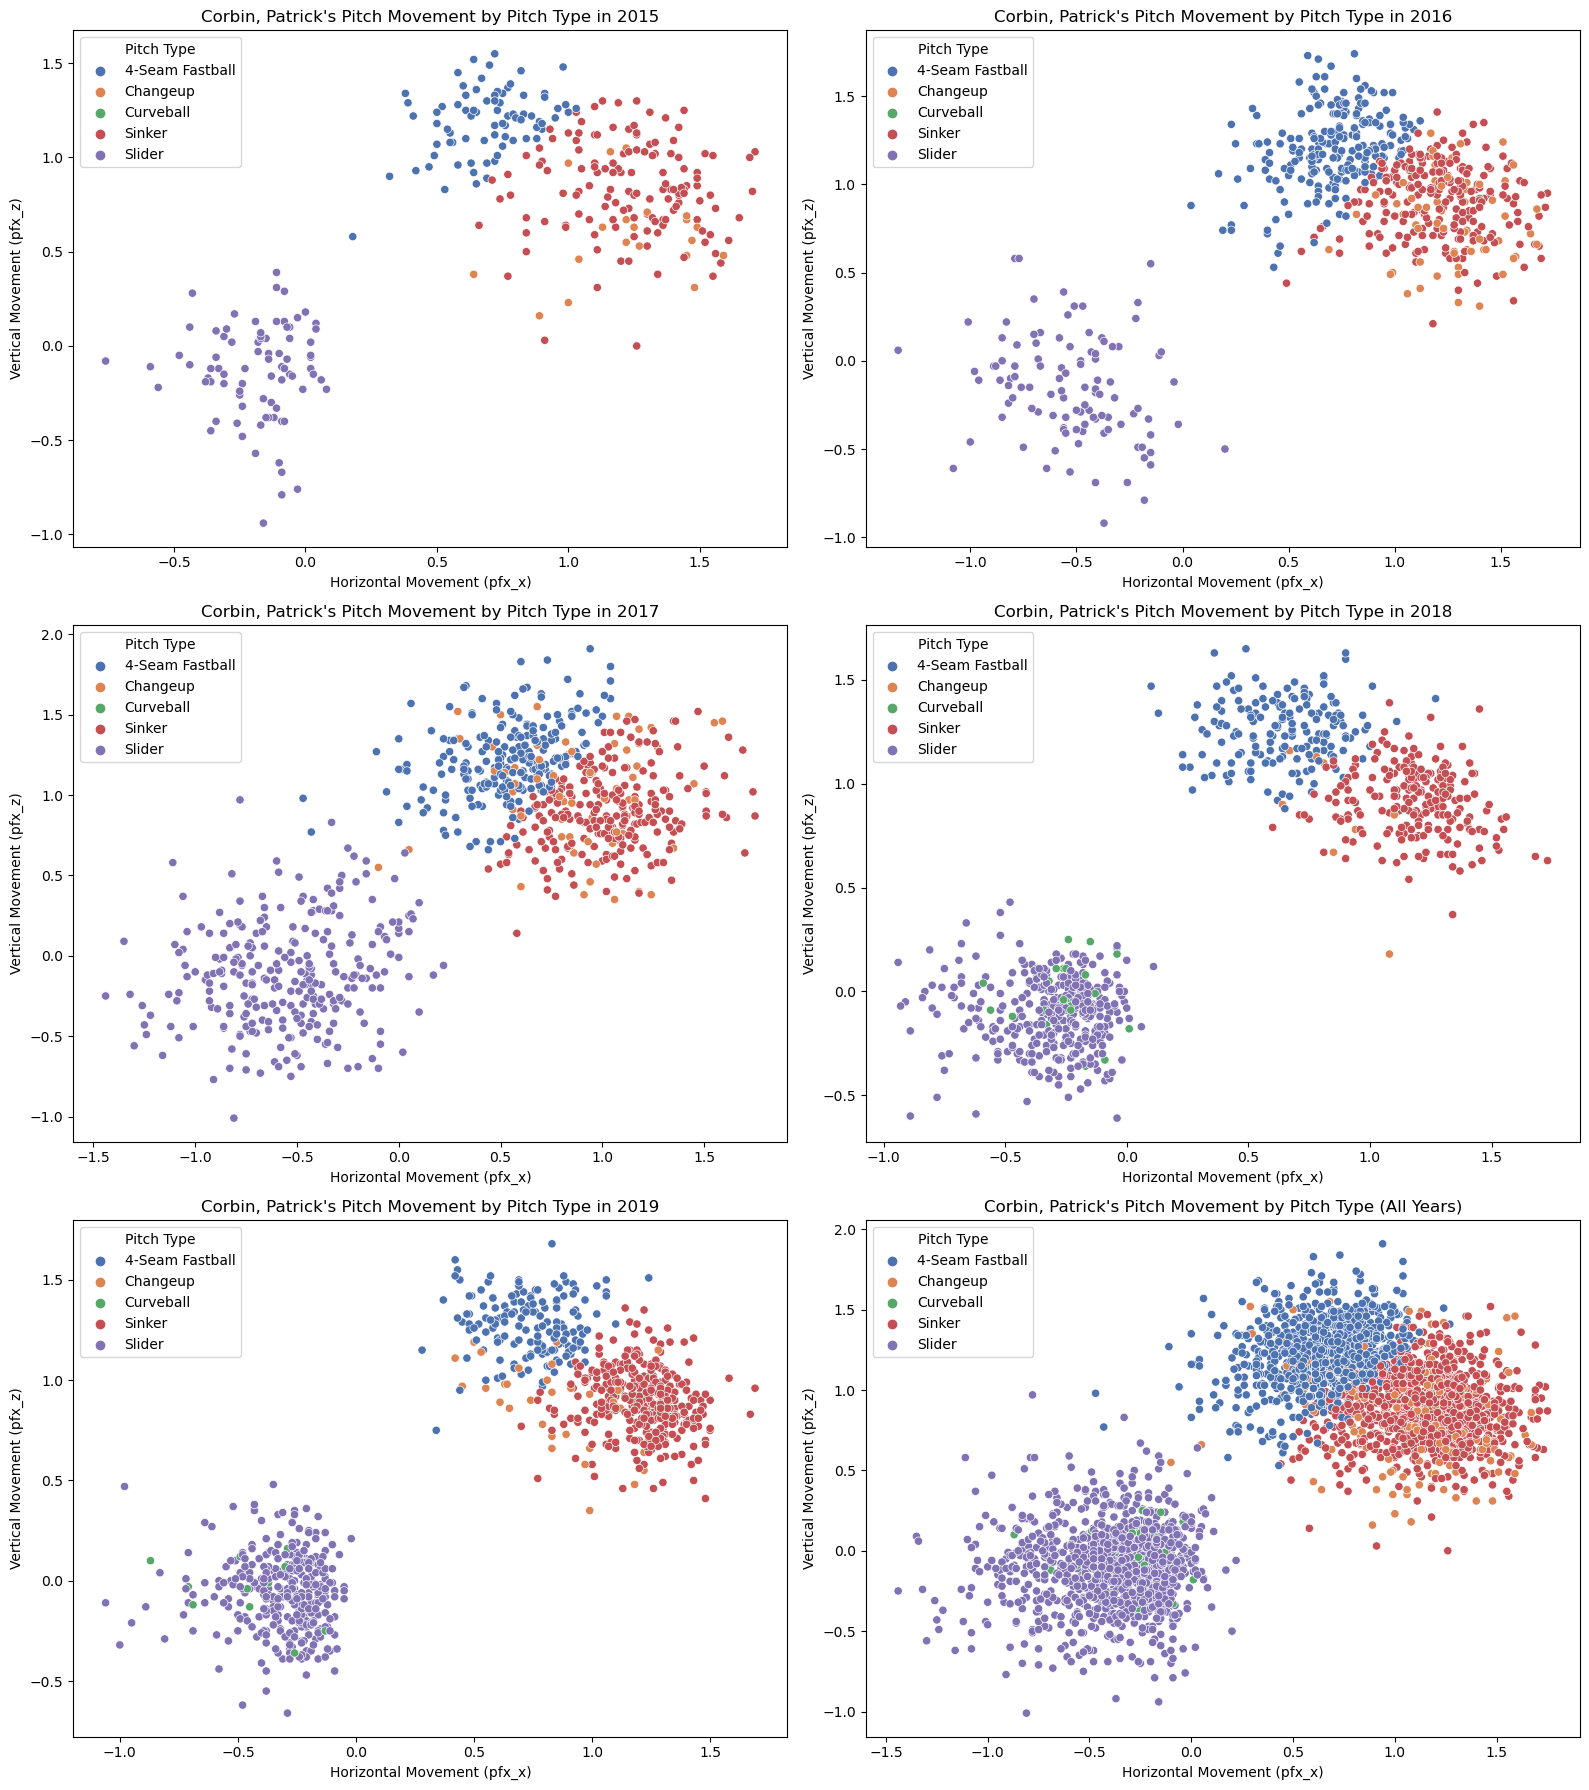

In [197]:
scatter_of_5_Years(pat_df)

In [193]:
firstname = 'Clayton'
lastname = 'Kershaw'
player_name = 'Clayton Kershaw'
cla_df = get_pitchers_info(firstname, lastname)

Pitcher ID:477132
Gathering Player Data
Loaded data for pitcher Clayton Kershaw from 2015-04-06 00:00:00 to 2019-10-09 00:00:00
with 3677 data points and 23 features



/Users/baohu/anaconda3/lib/python3.11/site-packages/pybaseball/utils.py:295: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(data.text))


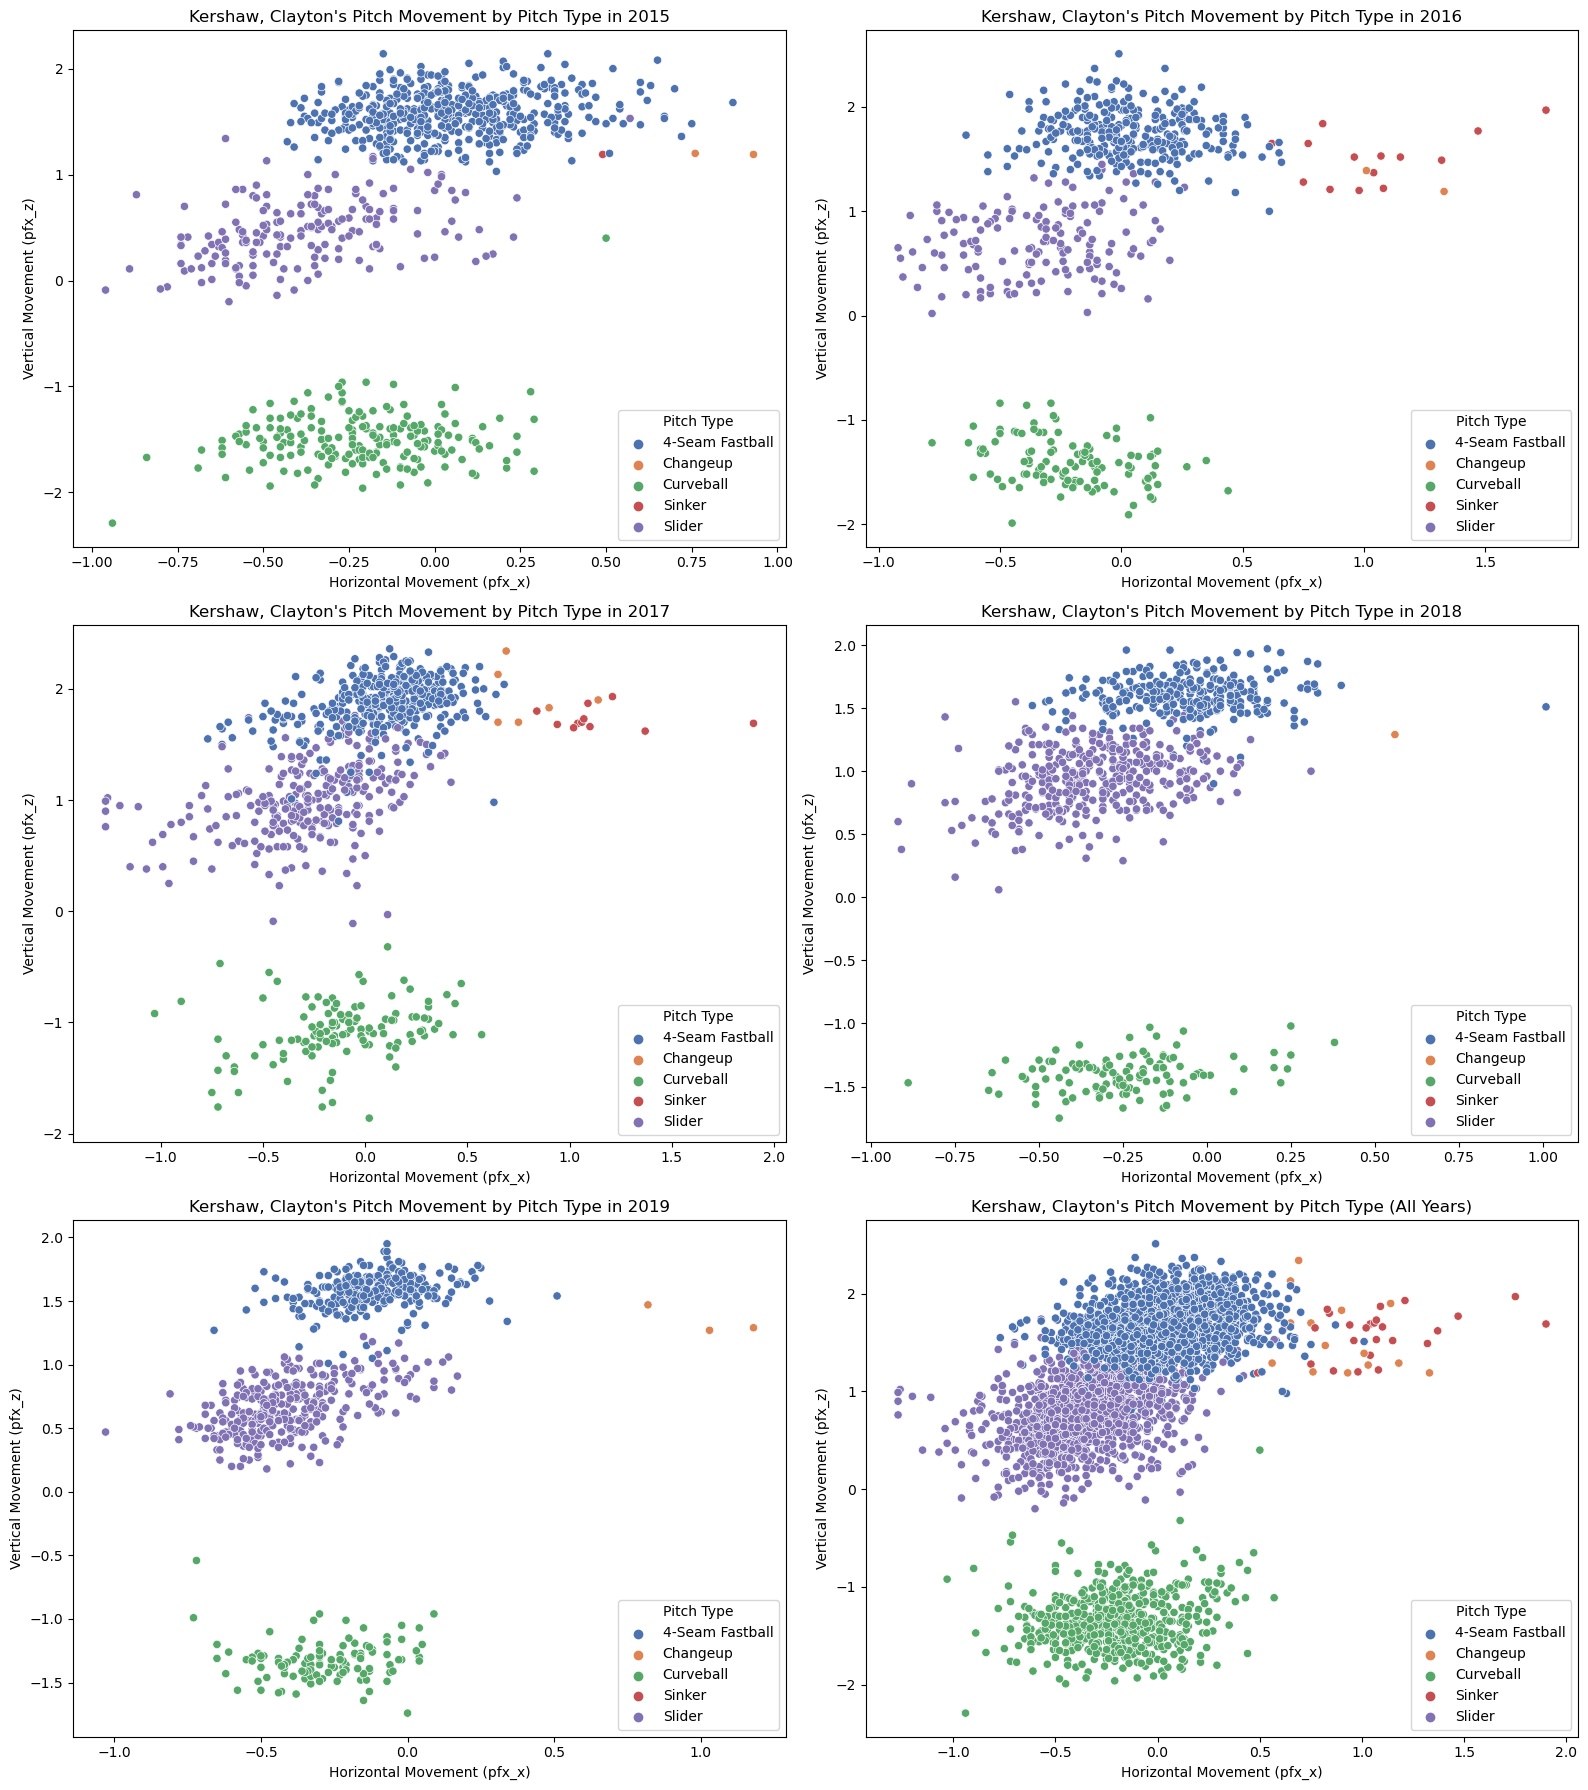

In [198]:
scatter_of_5_Years(cla_df)